<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/NEW_SVM(GFI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Basic SVM

In [26]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()


/tmp/ipython-input-670492372.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [27]:
# Ensure the date index is set for easy filtering
df.index = pd.to_datetime(df.index)

# Train = 2014-01-01 to 2023-12-31
train = df.loc["2014-01-01":"2023-12-31"]

# Test = 2024-01-01 to 2024-12-31
test = df.loc["2024-01-01":"2024-12-31"]

# Features & Target
X_train = train[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train['Target']

X_test = test[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test = test['Target']


In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit only on train
X_test_scaled = scaler.transform(X_test)         # transform test (no leakage)


In [29]:
from sklearn.svm import SVC

# Create SVM model (RBF kernel commonly used for classification)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Train on 2014–2023
svm_model.fit(X_train_scaled, y_train)


SVC(random_state=42)

Accuracy (2024): 0.46184738955823296


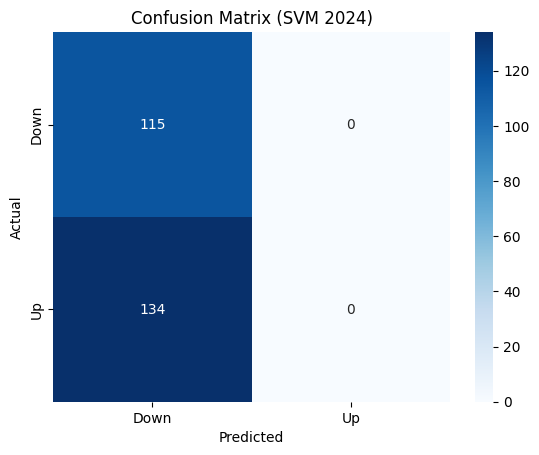

              precision    recall  f1-score   support

           0       0.46      1.00      0.63       115
           1       0.00      0.00      0.00       134

    accuracy                           0.46       249
   macro avg       0.23      0.50      0.32       249
weighted avg       0.21      0.46      0.29       249



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
# Predict 2024
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
print("Accuracy (2024):", accuracy_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SVM 2024)")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [31]:
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())

# Check for missing values
print("Missing values:", df.isnull().sum())


Train shape: (2538, 5) Test shape: (249, 5)
Train period: 2014-01-01 00:00:00 to 2023-12-29 00:00:00
Test period: 2024-01-02 00:00:00 to 2024-12-30 00:00:00
Missing values: Price   Ticker
Close   GFI.JO    0
High    GFI.JO    0
Low     GFI.JO    0
Open    GFI.JO    0
Volume  GFI.JO    0
Target            0
dtype: int64


# Added features

In [32]:
import pandas as pd
import numpy as np
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-3287618951.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [34]:
# -------------------------------
# Feature Engineering
# -------------------------------
df = df.copy()

# 1. Lagged Returns (1–5 days)
df['Return'] = df['Close'].pct_change()
for lag in range(1, 6):
    df[f'Return_t-{lag}'] = df['Return'].shift(lag)

# 2. Lagged Volume (1–5 days)
for lag in range(1, 6):
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)

# 3. Ratios & Normalisations
df['Close_SMA20'] = df['Close'] / df['Close'].rolling(20).mean()  # only keep ratio
df['High_Low'] = df['High'] / df['Low']
df['Close_Open'] = df['Close'] / df['Open']


# 4. Volatility & Risk
df['RollingStd_20'] = df['Close'].rolling(20).std()
df['ATR_14'] = (df['High'] - df['Low']).rolling(14).mean()
df['SquaredReturn'] = df['Return']**2

# 5. Momentum & ROC
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
df['ROC_5'] = df['Close'].pct_change(5)
df['ROC_10'] = df['Close'].pct_change(10)


# RSI (14)
delta = df['Close'].diff()

gain = delta.where(delta > 0, 0)   # keep positive diffs
loss = -delta.where(delta < 0, 0)  # keep negative diffs

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))



# MACD (12,26) and Signal (9)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger %B (20, 2 std)
sma20 = df['Close'].rolling(20).mean()
std20 = df['Close'].rolling(20).std()
upper = sma20 + 2 * std20
lower = sma20 - 2 * std20
df['Bollinger_%B'] = (df['Close'] - lower) / (upper - lower)

# 7. Volume Indicators
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df['MFI'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
df['VPT'] = (df['Volume'] * (df['Close'].pct_change())).cumsum()

# 8. Z-Scores
for win in [5, 10, 20]:
    rolling_mean = df['Close'].rolling(win).mean()
    rolling_std = df['Close'].rolling(win).std()
    df[f'ZScore_{win}'] = (df['Close'] - rolling_mean) / rolling_std

# 9. Sharpe-like ratio
df['SharpeLike_20'] = df['Return'].rolling(20).mean() / df['Return'].rolling(20).std()

# -------------------------------
# Finalise Dataset
# -------------------------------
df.dropna(inplace=True)

# Define Features (same for KNN, SVM, RF, XGBoost)
features = [
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Close_SMA20','High_Low','Close_Open',
    'RollingStd_20','ATR_14','SquaredReturn',
    'Momentum_5','Momentum_10','ROC_5','ROC_10',
    'RSI_14','MACD','MACD_Signal','Bollinger_%B',
    'OBV','MFI','VPT',
    'ZScore_5','ZScore_10','ZScore_20',
    'SharpeLike_20'
]

X = df[features]
y = df['Target']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature matrix shape: (2977, 31)
Target distribution:
 Target
0    1525
1    1452
Name: count, dtype: int64


In [35]:
# Split dataset into train (2014–2023) and test (2024)
train = df.loc["2014-01-01":"2023-12-31"]
test = df.loc["2024-01-01":"2024-12-31"]

X_train = train[features]
y_train = train["Target"]

X_test = test[features]
y_test = test["Target"]

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (2497, 31) Test size: (249, 31)


In [36]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Accuracy (2024): 0.5180722891566265

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.55      0.51       115
           1       0.56      0.49      0.52       134

    accuracy                           0.52       249
   macro avg       0.52      0.52      0.52       249
weighted avg       0.52      0.52      0.52       249



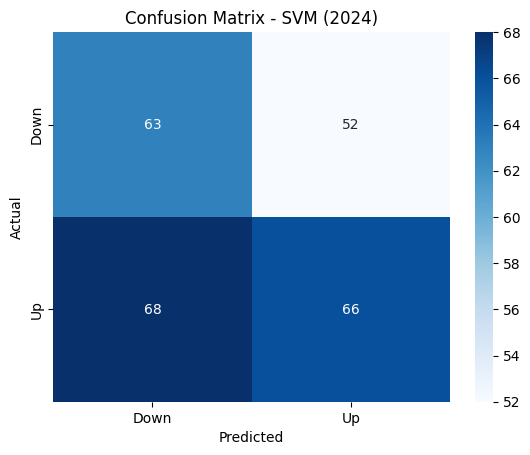

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM using all features (scaled)
svm_model = SVC(kernel='rbf',
                C=1,
                gamma='scale',
                class_weight='balanced',
                random_state=42)

# Fit on training set
svm_model.fit(X_train_scaled, y_train)

# Predict on 2024 test set
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
print("Accuracy (2024):", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM (2024)")
plt.show()
